# Deep Learning Project
## Istanbul Technical University
### Computer Engineering Department
### BLG 527E - Deep Learning
### Fall 2023

<b>Student Name: Muhammed Rüşen Birben</b><br>
<b>Student ID: 150220755</b><br>
<b>Student Email: birben20@itu.edu.tr</b><br>

<b>Student Name: Ahmed Burak Ercan</b><br>
<b>Student ID: 150220749</b><br>
<b>Student Email: ercana20@itu.edu.tr</b><br>

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from os import makedirs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
# custom modules
import Scripts.utils
import Scripts.model
# Reloading custom modules, for production purposes
reload(Scripts.utils)
reload(Scripts.model)
from Scripts.utils import get_model, model_predict, eval_model
from Scripts.model import TextDataset

### Loading the Data

In [29]:
# Reading the data.
df = pd.read_csv('Data/datasetV2.csv')
df.head()

,Source,Text,IsAI
0,LLM,Have you ever heard of the Crusades? A time in...,1
1,LLM,"The professors, who likely have nearly a decad...",1
2,LLM,Kemba Walker does a good job of defending Foye...,1
3,LLM,"Ganias' lawyer, Stanley Twardy, urged the gove...",1
4,LLM,The Circuit Court of Appeals of New Jersey had...,0


In [30]:
# Splitting the DataFrame into train and remaining datasets
# get a portion of the dataset
df = df.sample(frac=0.1, random_state=42)
df = df[:1000] # might increase this later

# Splitting the DataFrame into train and validation and test datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)



### Model Development

In [31]:
# setting up three models
model_names = ["roberta-base-openai-detector"]
models = dict()
model_tokenizers = dict()

for model_name in model_names:
    models[model_name], model_tokenizers[model_name] = get_model(model_name)

Model already exists, loading...


testing the out-of-the-box models on the dataset

In [32]:
# test all three models on the same data
model_confusion_matrices = {}

for model_name in model_names:
    print(model_name)
    predictions = model_predict(models[model_name], model_tokenizers[model_name], test_df['Text'].tolist())
    model_confusion_matrices[model_name] = eval_model(predictions, test_df['IsAI'].tolist())

roberta-base-openai-detector


100%|██████████| 2/2 [00:11<00:00,  5.64s/it]

Accuracy: 67.50%
Recall: 67.73%
Precision: 67.60%
F1-score: 67.46%


### Fine-Tuning

tokenizing the data for each model

In [34]:
tokens = list()
loaders = list()

for model_name in model_names:
    train_encodings = model_tokenizers[model_name](train_df['Text'].tolist(), truncation=True, padding=True)
    val_encodings = model_tokenizers[model_name](val_df['Text'].tolist(), truncation=True, padding=True)
    test_encodings = model_tokenizers[model_name](test_df['Text'].tolist(), truncation=True, padding=True)
    tokens.append({'train': train_encodings, 'val': val_encodings, 'test': test_encodings})    
    loaders.append({'train': TextDataset(train_encodings, train_df['IsAI'].tolist()), 
                    'val': TextDataset(val_encodings, val_df['IsAI'].tolist()), 
                    'test': TextDataset(test_encodings, test_df['IsAI'].tolist())})

In [35]:
fine_tuned_model_confusion_matrices = {}
model_scores = {}

# Define training arguments
for i in range(len(model_names)):
    training_args = TrainingArguments(
        output_dir="./results",          # output directory
        num_train_epochs=3,              # total number of training epochs
        per_device_train_batch_size=2,   # batch size per device during training
        per_device_eval_batch_size=2,    # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.02,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=300,
        evaluation_strategy="epoch"      # evaluate each `logging_steps`
    )

    # Initialize Trainer
    trainer = Trainer(
        model=models[model_names[i]],        # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=loaders[i]['train'],         # training dataset
        eval_dataset=loaders[i]['val']             # evaluation dataset
    )

    # Train and evaluate
    trainer.train()

    # Evaluate on test set

    print(f"Evaluation of the model: {model_names[i]}")

    predictions = trainer.predict(loaders[i]['test'])
    predictions = np.argmax(predictions.predictions, axis=-1)
    fine_tuned_model_confusion_matrices[model_names[i]], scores = eval_model(predictions, test_df['IsAI'].tolist(), return_scores=True)
    model_scores[model_names[i]] = {k: v for k, v in scores.items() if k in ['accuracy', 'f1-score', 'precision', 'recall']}
    print()

    # Save the model
    trainer.save_model(f"Models/fine_tuned/{model_names[i]}")

 10%|█         | 100/960 [00:30<04:18,  3.33it/s]

{'loss': 0.8121, 'learning_rate': 1e-05, 'epoch': 0.31}


 21%|██        | 200/960 [01:00<03:47,  3.35it/s]

{'loss': 0.5318, 'learning_rate': 2e-05, 'epoch': 0.62}


 31%|███▏      | 300/960 [01:30<03:17,  3.35it/s]

{'loss': 0.504, 'learning_rate': 3e-05, 'epoch': 0.94}


 33%|███▎      | 320/960 [01:39<03:12,  3.33it/s]

{'eval_loss': 0.2555827498435974, 'eval_runtime': 3.321, 'eval_samples_per_second': 48.178, 'eval_steps_per_second': 24.089, 'epoch': 1.0}


 42%|████▏     | 400/960 [02:04<02:49,  3.31it/s]

{'loss': 0.4199, 'learning_rate': 4e-05, 'epoch': 1.25}


 52%|█████▏    | 500/960 [02:34<02:16,  3.36it/s]Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 0.307, 'learning_rate': 5e-05, 'epoch': 1.56}


 62%|██████▎   | 600/960 [03:06<01:48,  3.32it/s]

{'loss': 0.3697, 'learning_rate': 3.91304347826087e-05, 'epoch': 1.88}


 67%|██████▋   | 640/960 [03:21<01:36,  3.33it/s]

{'eval_loss': 0.3357124924659729, 'eval_runtime': 3.1756, 'eval_samples_per_second': 50.385, 'eval_steps_per_second': 25.192, 'epoch': 2.0}


 73%|███████▎  | 700/960 [03:39<01:26,  3.00it/s]

{'loss': 0.2804, 'learning_rate': 2.826086956521739e-05, 'epoch': 2.19}


 83%|████████▎ | 800/960 [04:11<00:51,  3.08it/s]

{'loss': 0.1156, 'learning_rate': 1.739130434782609e-05, 'epoch': 2.5}


 94%|█████████▍| 900/960 [04:42<00:20,  2.90it/s]

{'loss': 0.039, 'learning_rate': 6.521739130434783e-06, 'epoch': 2.81}


100%|██████████| 960/960 [05:06<00:00,  3.14it/s]


{'eval_loss': 0.3998672366142273, 'eval_runtime': 3.536, 'eval_samples_per_second': 45.249, 'eval_steps_per_second': 22.625, 'epoch': 3.0}
{'train_runtime': 306.1129, 'train_samples_per_second': 6.272, 'train_steps_per_second': 3.136, 'train_loss': 0.3550250249604384, 'epoch': 3.0}
Evaluation of the model: roberta-base-openai-detector


100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Accuracy: 89.00%
Recall: 89.36%
Precision: 89.05%
F1-score: 88.98%


### Visualizing the Results

confusion matrix for each model before and after fine-tuning

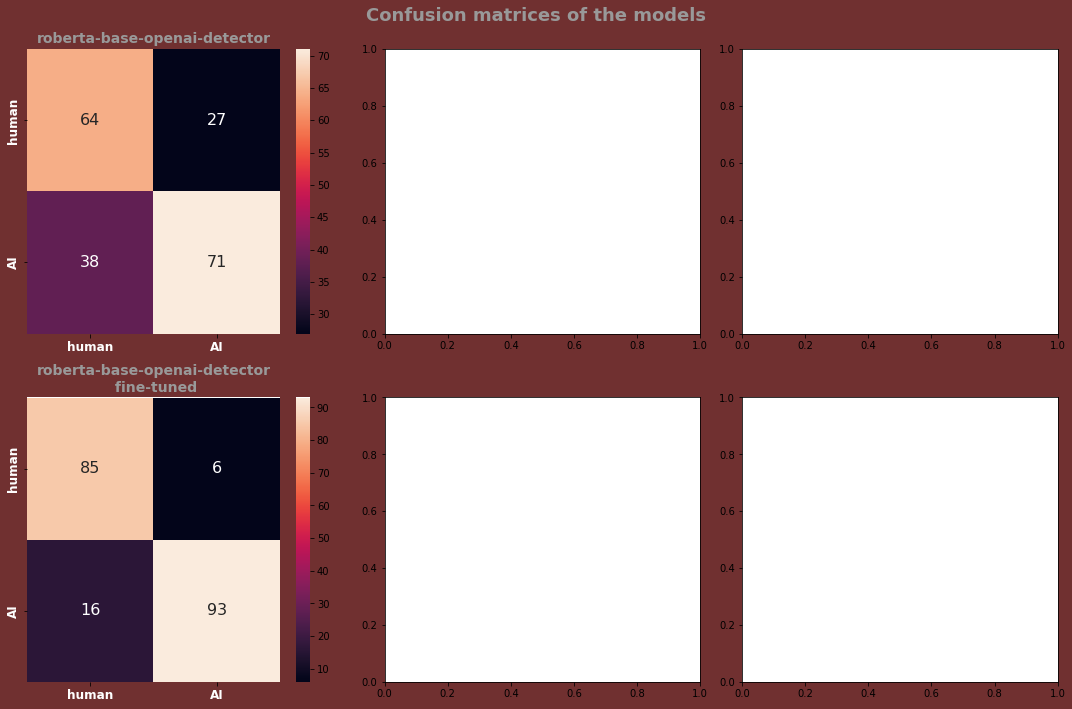

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Confusion matrices of the models', fontsize=18, fontweight='bold', color='#999999')
fig.set_facecolor('#703030')
for i in range(len(model_names)):
    sns.heatmap(model_confusion_matrices[model_names[i]], annot=True, ax=ax[0][i], annot_kws={"size": 16})
    ax[0][i].set_title(model_names[i], fontweight='bold', fontsize=14, color='#999999')
    sns.heatmap(fine_tuned_model_confusion_matrices[model_names[i]], annot=True, ax=ax[1][i], annot_kws={"size": 16})
    ax[1][i].set_title(model_names[i] + '\n fine-tuned', fontweight='bold', fontsize=14, color='#999999')

    # change x and y labels. map 0 to 'human' and 1 to 'AI'
    ax[0][i].set_xticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')
    ax[0][i].set_yticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')
    ax[1][i].set_xticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')
    ax[1][i].set_yticklabels(['human', 'AI'], fontweight='bold', fontsize=12, color='white')

plt.tight_layout()
plt.show()